In [1]:
!pip install qulacs

     |████████████████████████████████| 451 kB 3.2 MB/s 
You should consider upgrading via the '/home/nozomu/.pyenv/versions/3.7.9/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
from qulacs import QuantumState,QuantumCircuit
from qulacs import ParametricQuantumCircuit
from qulacs.gate import RY,CZ,merge
from qulacs.state import inner_product
import numpy as np 

### Prepare training/test data

In [197]:
n_qubits = 5

# 用いるスタビライザー群の要素を決定する
S = np.zeros((n_qubits, 2*n_qubits))
S[0] = np.array([1,0, 0,1, 0,0, 0,0, 0,0]) # XZIII (X->1,0 Z->0,1 I->0,0としてならべる)
S[1] = np.array([0,1, 1,0, 0,1, 0,1, 0,0]) # ZXZZI
S[2] = np.array([0,0, 0,1, 1,0, 0,0, 0,0]) # IZXII
S[3] = np.array([0,0, 0,1, 0,0, 1,0, 0,1]) # IZIXZ
S[4] = np.array([0,0, 0,0, 0,0, 0,1, 1,0]) # IIIZX

def x_generator(c):
    SS = np.copy(S)

    select = np.random.randint(0,2,n_qubits) # i番目の生成元を使う(1)か使わない(0)かを決める行列
    for i in range(n_qubits):
        SS[i] = SS[i] * select[i]
    op = np.sum(SS, axis=0) # それぞれのビットにそれぞれのゲート(X, Z)が何回掛かるかを示す行列

    # \theta_{+-}を計算する
    theta = np.zeros(2*n_qubits)

    for i in range(n_qubits):
        theta[2*i] = c[2*i] + np.pi/2 * op[2*i]
        theta[2*i+1] = (-1)**op[2*i] * c[2*i+1] + np.pi/2 * op[2*i+1]

    for i in range(2*n_qubits): # 0～\piの値にする
        theta[i] = theta[i] % np.pi
    
    return theta

In [198]:
n_data_train = 50
epsilon = 0.0 # エラーの分散
e = np.random.normal(0, np.sqrt(epsilon), (2*n_data_train, 2*n_qubits))

# c_{+-}を決める
c_plus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4 # - \pi/4 ～ \pi/4 のランダムな数
c_minus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4

x_plus = x_generator(c_plus).reshape((1,-1))
x_minus = x_generator(c_minus).reshape((1,-1))
for i in range(n_data_train-1):
    xx = x_generator(c_plus).reshape((1,-1))
    x_plus = np.concatenate([x_plus, xx])
    xx = x_generator(c_minus).reshape((1,-1))
    x_minus = np.concatenate([x_minus, xx])
x_train = np.concatenate([x_plus, x_minus]) + e

y_plus = np.ones(n_data_train)
y_minus = -np.ones(n_data_train)
y_train = np.concatenate([y_plus, y_minus]).reshape(1,-1)
print(x_train)
print(y_train)

[[2.75141606 3.13379156 0.75320889 0.11285949 2.71511654 3.00812025
  0.34368811 2.34925505 2.2182661  0.36831164]
 [1.18061974 1.57859742 2.32400522 3.02873316 2.71511654 1.43732392
  1.91448444 0.7923376  0.64746977 1.20248468]
 [1.18061974 1.57859742 2.32400522 1.45793683 1.14432021 1.70426873
  1.91448444 2.36313393 2.2182661  1.93910797]
 [2.75141606 3.13379156 0.75320889 0.11285949 2.71511654 3.00812025
  0.34368811 0.77845872 0.64746977 2.77328101]
 [2.75141606 3.13379156 0.75320889 1.68365582 2.71511654 3.00812025
  1.91448444 0.7923376  2.2182661  1.93910797]
 [1.18061974 0.0078011  0.75320889 1.68365582 1.14432021 0.13347241
  1.91448444 0.7923376  2.2182661  1.93910797]
 [1.18061974 0.0078011  0.75320889 0.11285949 2.71511654 3.00812025
  1.91448444 0.7923376  2.2182661  1.93910797]
 [1.18061974 1.57859742 2.32400522 3.02873316 2.71511654 1.43732392
  1.91448444 0.7923376  0.64746977 1.20248468]
 [2.75141606 3.13379156 0.75320889 0.11285949 2.71511654 3.00812025
  0.34368811

In [202]:
y_train = y_train.T

In [201]:
x_train.shape

(100, 10)

In [190]:
n_qubits = 5

S_group = np.zeros((n_qubits, 2*n_qubits))
S_group[0] = np.array([1,0, 0,1, 0,0, 0,0, 0,0]) # XZIII (X->1,0 Z->0,1 I->0,0としてならべる)
S_group[1] = np.array([0,1, 1,0, 0,1, 0,1, 0,0]) # ZXZZI
S_group[2] = np.array([0,0, 0,1, 1,0, 0,0, 0,0]) # IZXII
S_group[3] = np.array([0,0, 0,1, 0,0, 1,0, 0,1]) # IZIXZ
S_group[4] = np.array([0,0, 0,0, 0,0, 0,1, 1,0])

def x_generator(c,S):
    op = np.copy(S)

    theta = np.zeros(2*n_qubits)

    for i in range(n_qubits):
        theta[2*i] = c[2*i] + np.pi/2 * op[2*i]
        theta[2*i + 1] = (-1)**op[2*i] * c[2*i+1] + np.pi/2 * op[2*i+1]
    
    #theta = theta % np.pi 

    return theta 

In [191]:
n_data_train = 50
epsilon = 0.0 # エラーの分散
e = np.random.normal(0, np.sqrt(epsilon), (2*n_data_train, 2*n_qubits))

S = S_group[0]

# c_{+-}を決める

np.random.seed(1111)
x_plus = []
x_minus = []
for i in range(n_data_train): 
    c_plus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4 # - \pi/4 ～ \pi/4 のランダムな数
    c_minus = np.pi/2 * np.random.rand(2*n_qubits) - np.pi/4

    x_p = x_generator(c_plus,S).reshape((1,-1))
    x_m = x_generator(c_minus,S).reshape((1,-1))
    x_plus.append(x_p)
    x_minus.append(x_m)
x_plus = np.concatenate(x_plus)
x_minus = np.concatenate(x_minus)
x_train = np.concatenate([x_plus,x_minus])

y_plus = np.ones(n_data_train)
y_minus = -np.ones(n_data_train)
y_train = np.concatenate([y_plus, y_minus])

In [214]:
x_train

array([[2.75141606, 3.13379156, 0.75320889, 0.11285949, 2.71511654,
        3.00812025, 0.34368811, 2.34925505, 2.2182661 , 0.36831164],
       [1.18061974, 1.57859742, 2.32400522, 3.02873316, 2.71511654,
        1.43732392, 1.91448444, 0.7923376 , 0.64746977, 1.20248468],
       [1.18061974, 1.57859742, 2.32400522, 1.45793683, 1.14432021,
        1.70426873, 1.91448444, 2.36313393, 2.2182661 , 1.93910797],
       [2.75141606, 3.13379156, 0.75320889, 0.11285949, 2.71511654,
        3.00812025, 0.34368811, 0.77845872, 0.64746977, 2.77328101],
       [2.75141606, 3.13379156, 0.75320889, 1.68365582, 2.71511654,
        3.00812025, 1.91448444, 0.7923376 , 2.2182661 , 1.93910797],
       [1.18061974, 0.0078011 , 0.75320889, 1.68365582, 1.14432021,
        0.13347241, 1.91448444, 0.7923376 , 2.2182661 , 1.93910797],
       [1.18061974, 0.0078011 , 0.75320889, 0.11285949, 2.71511654,
        3.00812025, 1.91448444, 0.7923376 , 2.2182661 , 1.93910797],
       [1.18061974, 1.57859742, 2.3240052

In [50]:
def create_featured_gate(n_qubits,Lambda,edges,x):
    circuit = ParametricQuantumCircuit(n_qubits)
    for i in range(n_qubits):
        circuit.add_parametric_RY_gate(i,Lambda[i])
    for control, target  in edges:
        circuit.add_CZ_gate(control,target)

    for i in range(n_qubits):
        circuit.add_RZ_gate(i,x[2*i])
        circuit.add_RX_gate(i,x[2*i+1])

    return circuit


In [51]:
edges= [[0,1],[1,2],[1,3],[3,4]]

In [52]:
def get_kernel_value(x1,x2,Lambda):

    state1 = QuantumState(n_qubits)
    state2 = QuantumState(n_qubits)
    state1.set_zero_state()
    state1.set_zero_state()

    circuit1 = create_featured_gate(n_qubits,Lambda,edges,x1)
    circuit2 = create_featured_gate(n_qubits,Lambda,edges,x2)
    
    circuit1.update_quantum_state(state1)

    circuit2.update_quantum_state(state2)

    return abs(inner_product(state1,state2))**2
    

In [53]:
def construct_kernel_matrix(Lambda,x):

    kernel_matrix = np.identity(x.shape[0])
    for i in range(x.shape[0]):
        for j in range(i):
            kernel_matrix[i,j] = get_kernel_value(x[i],x[j],Lambda)
            kernel_matrix[j,i] = kernel_matrix[i,j].conjugate()
    
    return kernel_matrix

In [56]:
from cvxopt import matrix, solvers

In [138]:
def cvxopt_solver(Kernel,y,C):
    
    P = matrix(np.outer(y,y) * Kernel )
    q = matrix(- np.ones(y.shape[0]))
    n = Kernel.shape[0] 

    G = matrix(np.vstack(( - np.eye(n), np.eye(n)  ))) 
    h = matrix(np.vstack((np.zeros((n, 1)), np.full((n, 1),C) )))
    A = matrix(y, (1,n))
    b = matrix(np.zeros(1), (1, 1))

    solvers.options["maxiters"] = 10000
    solvers.options["show_progress"] = False

    sol = solvers.qp(P,q,G,h,A,b,max)
    return sol 

In [225]:
C = 1 # box parameter (論文には0以上の任意の値と書いてあるが、どんな値にすればよいかわからん)
P = 20 # SPSAの回数
c = 0.1 # 論文Algorithm 1中のc（定数とだけ書いてあるが、どんな値にすればよいかわからん）
gamma = 1 # 論文Algorithm 1中の\gamma（定数とだけ書いてあるが、どんな値にすればよいかわからん）
a = 0.1
A = 1
sigma = 1

lam_initial = .1 # \lambdaの初期値
lam_history = []
F_history = []
K_history = []
alpha_history = []

np.random.seed(1111)
lam0 = lam_initial
lam = np.full(n_qubits, lam0)
for i in range(P):
    
    c_i =  c / (i + 1)** gamma
    a_i = a / ( i + 1 + A)** sigma
    # 6行目
    Delta = 2*np.random.randint(0, 2, n_qubits) - 1 # ランダムに{-1, 1}を生成
    # 7行目
    lam_plus = lam + c_i * Delta
    lam_minus = lam - c_i * Delta
    # 8行目
    K = construct_kernel_matrix(lam, x_train)
    K_plus = construct_kernel_matrix(lam_plus, x_train)
    K_minus = construct_kernel_matrix(lam_minus, x_train)
    # 9行目(cvxoptを用いるためにいろんな計算をしている)
    sol = cvxopt_solver(K,y_train,C)
    sol_plus = cvxopt_solver(K_plus,y_train,C)
    sol_minus = cvxopt_solver(K_minus,y_train,C)
    alpha_plus = np.array(sol_plus['x']).reshape(-1)
    alpha_minus = np.array(sol_minus['x']).reshape(-1)
    # 10行目
    F_plus = - sol_plus['primal objective']
    F_minus = - sol_minus['primal objective']
    F = - sol['primal objective']
    lam = lam - (F_plus - F_minus)* Delta* a_i / (2 *c_i)
    # データの保存
    lam_history.append(lam)
    F_history.append(F)
    K_history.append(K)
    #alpha_history.append(alpha)

In [226]:
lam_history

[array([-0.47181863,  0.67181863,  0.67181863,  0.67181863, -0.47181863]),
 array([-0.72987981,  0.41375745,  0.41375745,  0.41375745, -0.72987981]),
 array([-1.10601514,  0.78989279,  0.78989279,  0.78989279, -0.35374448]),
 array([-0.92382331,  0.97208462,  0.97208462,  0.97208462, -0.53593631]),
 array([-1.02656052,  1.07482184,  1.07482184,  0.86934741, -0.63867353]),
 array([-0.93738731,  1.16399505,  1.16399505,  0.95852062, -0.72784674]),
 array([-1.13704544,  1.36365318,  1.36365318,  1.15817875, -0.92750487]),
 array([-1.18256633,  1.31813228,  1.31813228,  1.20369964, -0.88198397]),
 array([-1.19832961,  1.30236901,  1.30236901,  1.21946292, -0.8662207 ]),
 array([-1.23697584,  1.34101524,  1.34101524,  1.25810915, -0.82757446]),
 array([-1.32326645,  1.25472463,  1.25472463,  1.34439976, -0.91386507]),
 array([-1.32548577,  1.2525053 ,  1.2525053 ,  1.34218043, -0.9160844 ]),
 array([-1.26245253,  1.31553855,  1.31553855,  1.40521367, -0.97911764]),
 array([-1.27078644,  1.3

In [227]:
import numpy as np
import matplotlib.pyplot as plt

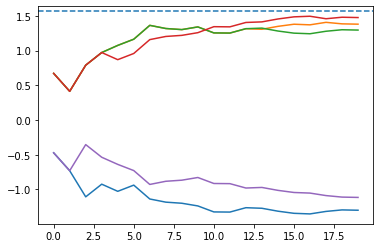

In [228]:
for i in range(5):
    x = np.arange(0,20,1)
    y = np.array(lam_history)[:,i]
    plt.plot(x,y)
plt.axhline(np.pi/2,linestyle='--')
plt.show()

In [30]:
class KernelMatrix:

    def __init__(self,n_qubit,Lambda,edges) -> None:
        self.n_qubit = n_qubit
        self.Lambda = Lambda
        self.edges = edges
        self.state1 = QuantumState(n_qubit)
        self.state2 = QuantumState(n_qubit)

    def make_fiducial_state(self,Lambda):
        circuit = ParametricQuantumCircuit(self.n_qubit)
        for i in range(self.n_qubit):
            circuit.add_parametric_RY_gate(Lambda)
        for control, target in self.edges:
            circuit.add_CZ_gate(control,target)
        return circuit

    def create_featured_gate(self,theta):
        circuit = ParametricQuantumCircuit(self.n_qubit)
        for i in range(self.n_qubit):
            circuit.add_parametric_RY_gate(i,self.Lambda)
        for control, target in self.edges:
            circuit.add_CZ_gate(control,target)

        for i in range(self.n_qubit):
            circuit.add_RZ_gate(i,theta[i,0])
            circuit.add_RX_gate(i,theta[i,1])

        return circuit
        
    def featured_gate(self,theta):
        circuit = QuantumCircuit(self.n_qubit)
        for i in range(self.n_qubit):
            circuit.add_RZ_gate(i,theta[i,0])
            circuit.add_RX_gate(i,theta[i,1])

        return circuit

    def get_kernel_value(self,x1,x2):
        self.state1.set_zero_state()
        self.state1.set_zero_state()
        fiducial_gate = self.make_fiducial_state()


        featured_gate1 = self.featured_gate(x1)
        featured_gate2 = self.featured_gate(x2)
        
        circuit1 = merge(fiducial_gate,featured_gate1)
        circuit1.update_quantum_state(state1)
        circuit2 = merge(fiducial_gate,featured_gate2)
        circuit2.update_quantum_state(state2)

        return inner_product(state1,state2)
    
    def construct_kernel_matrix(self,x_data):
        """
        Args:
            x_data : MxNxD array of data where N is the number of samples,
             N the number of qubits, D the feature dimension
        """
        kernel_matrix = np.identity(x_data.shape[0])
        for i in range(x_data.shape[0]):
            for j in range(i):
                kernel_matrix[i,j] = self.get_kernel_value(x_data[i],x_data[j])
                kernel_matrix[j,i] = kernel_matrix[i,j].conjugate()
        
        return kernel_matrix

    def spsa(self,x_data,y_label,n_step,initial_Lambda = 0.01):
        Lambda = initial_Lambda
        for i in n_step:
            Delta = 2 * np.random.rand() - 1

            c_i = c / ( i + 1)**gamma
            Lambda__pm_i = Lambda + np.array([Delta*c_i, - Delta*c_i])
            self.construct_kernel_matrix()



In [43]:
np.array([0,1 ]) + 1

array([1, 2])

In [33]:
KernelMatrix(2,np.pi,[[0,1]]).state1

 *** Quantum State ***
 * Qubit Count : 2
 * Dimension   : 4
 * State vector : 
(1,0)
(0,0)
(0,0)
(0,0)

In [ ]:
state1 = QuantumState(n)
state2 = QuantumState(n)
def get_kernel_value(x1,x2):
    state1.set_zero_state()
    create_featured_gate()